In [3]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
%pip install torchbnn

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

data = pd.read_csv('CombinedData.csv')
stop_words = set(stopwords.words('english'))



C:\Users\kanda\AppData\Local\Temp\ipykernel_15928\2349922668.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kanda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kanda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kanda\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<>:17: SyntaxWarning: invalid escape sequence '\S'
<>:17: SyntaxWarning: invalid escape sequence '\S'
C:\Users\kanda\AppData\Local\Temp\ipykernel_15928\509054687.py:17: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('\S*@\S*\s?', '', text)
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kanda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


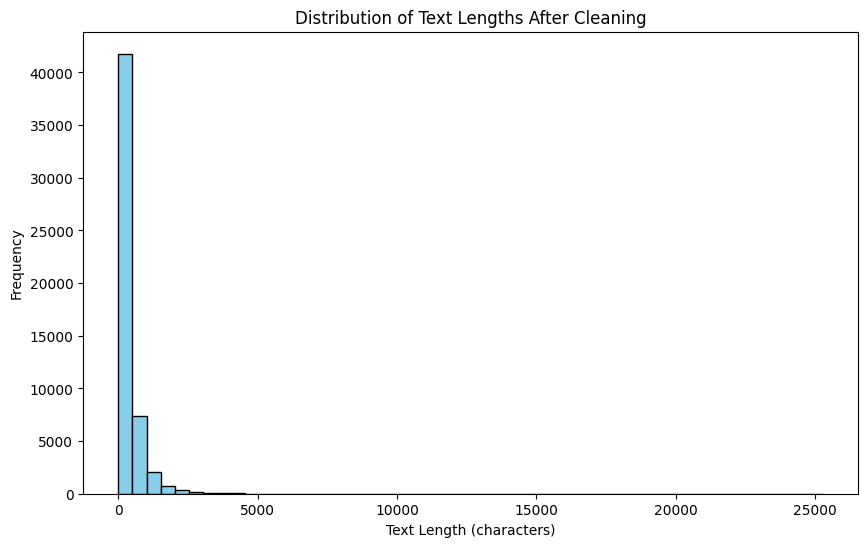

In [4]:
from textblob import TextBlob
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
import string
exclude = string.punctuation
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))
def clean_text(text):
    # Lowering letters
    text = text.lower()
    # Removing html tags
    text = re.sub('<[^>]*>', '', text)
    # Removing emails
    text = re.sub('\S*@\S*\s?', '', text)
    # Removing urls
    text = re.sub('https?://[A-Za-z0-9]','',text)
    # Removing numbers
    text = re.sub('[^a-zA-Z]',' ',text)
    word_tokens = word_tokenize(text)    
    filtered_sentence = []
    for word_token in word_tokens:
        if word_token not in stop_words:
            filtered_sentence.append(word_token)
    
    # Joining words
    text = (' '.join(filtered_sentence))
    #print(len(text))
    return text


data_cleaned = data[['statement', 'status']].dropna()

data_cleaned['statement'] = data_cleaned['statement'].apply(clean_text)
data_cleaned = data_cleaned[['statement', 'status']].dropna(subset=['statement'])

data_cleaned['text_length'] = data_cleaned['statement'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(data_cleaned['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths After Cleaning')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.show()
## Tokenization and Stopwords Removal
#stop_words = set(stopwords.words('english'))
#
#def remove_stopwords(text):
#    tokens = word_tokenize(text)
#    tokens = [word for word in tokens if word not in stop_words]
#    return ' '.join(tokens)
#
#data_cleaned['statement'] = data_cleaned['statement'].apply(lambda x: remove_stopwords(x))
#
## Data Augmentation
#def augment_text(text):
#    try:
#        blob = TextBlob(text)
#        translated = blob.translate(to='fr').translate(to='en')
#        return str(translated)
#    except Exception as e:
#        return text
#
#data_cleaned['augmented_statement'] = data_cleaned['statement'].apply(augment_text)
#augmented_df = data_cleaned[['statement', 'status']].copy()
#augmented_df['statement'] = data_cleaned['augmented_statement']
#data_cleaned = pd.concat([data_cleaned, augmented_df])
#
#data_cleaned['statement'] = data_cleaned['statement'].apply(lambda x: clean_text(x))
#data_cleaned['statement'] = data_cleaned['statement'].apply(lambda x: remove_stopwords(x))

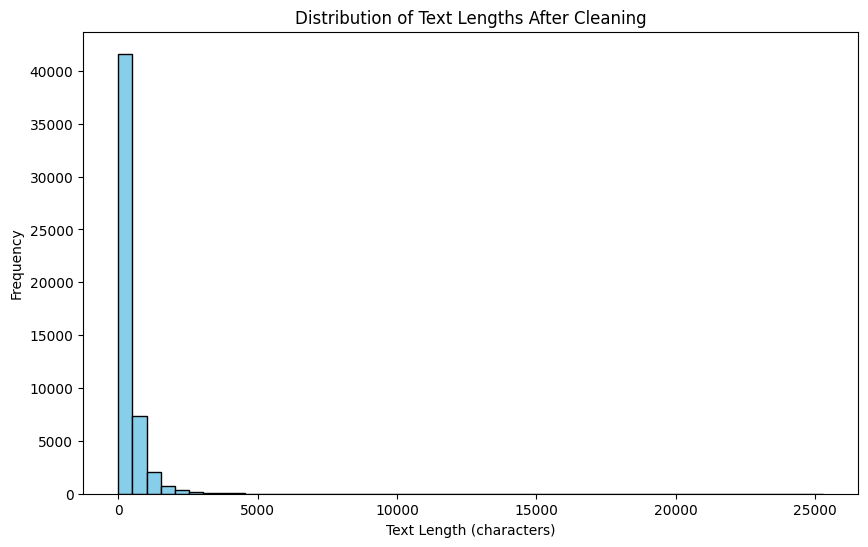

Maximum text length: 25289
Minimum text length: 1
Average: 333.91749200060946
Frequency of text entries with zero length: 3586


In [6]:
plt.figure(figsize=(10, 6))
plt.hist(data_cleaned['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths After Cleaning')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.show()
# Calculate max and min text length
max_length = data_cleaned['text_length'].max()
min_length = data_cleaned['text_length'].min()

print("Maximum text length:", max_length)
print("Minimum text length:", min_length)
print("Average:", data_cleaned['text_length'].mean())
data_cleaned = data_cleaned[data_cleaned['text_length'] != 0].reset_index(drop=True)

zero_length_count = data_cleaned[data_cleaned['text_length'] >1000].shape[0]

print("Frequency of text entries with zero length:", zero_length_count)

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import torchbnn as bnn  
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from torch.nn.utils.rnn import pad_sequence

# 1. Data Preprocessing

# Encoding labels (mental health categories)
label_encoder = LabelEncoder()
data_cleaned['status_encoded'] = label_encoder.fit_transform(data_cleaned['status'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data_cleaned['statement'],
    data_cleaned['status_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=data_cleaned['status_encoded']
)

# Convert text data into sequences of token IDs using CountVectorizer
vectorizer = CountVectorizer(max_features=5000, tokenizer=lambda x: x.split())
vectorizer.fit(X_train)

# Create sequences of token indices for LSTM
X_train_seq = [torch.tensor(vectorizer.transform([text]).toarray().argmax(axis=1)) for text in X_train]
X_test_seq = [torch.tensor(vectorizer.transform([text]).toarray().argmax(axis=1)) for text in X_test]

# Pad sequences to have consistent length
X_train_padded = pad_sequence(X_train_seq, batch_first=True).to(torch.long)
X_test_padded = pad_sequence(X_test_seq, batch_first=True).to(torch.long)

# Convert labels to tensor
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

print(y_train_tensor)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_padded, y_train_tensor)
test_dataset = TensorDataset(X_test_padded, y_test_tensor)

# DataLoader for batching
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

c:\Users\kanda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


tensor([6, 6, 5,  ..., 3, 1, 6])


tensor([0, 1, 2, 3, 4, 5, 6])
['Anxiety' 'Normal' 'Depression' 'Suicidal' 'Stress' 'Bipolar'
 'Personality disorder']


<Axes: xlabel='status', ylabel='count'>

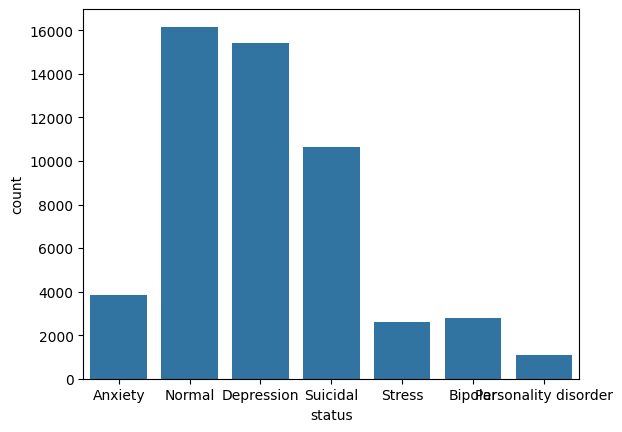

In [44]:
print(y_train_tensor[:20].unique())
print(data_cleaned['status'].unique())

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=data_cleaned, x='status')

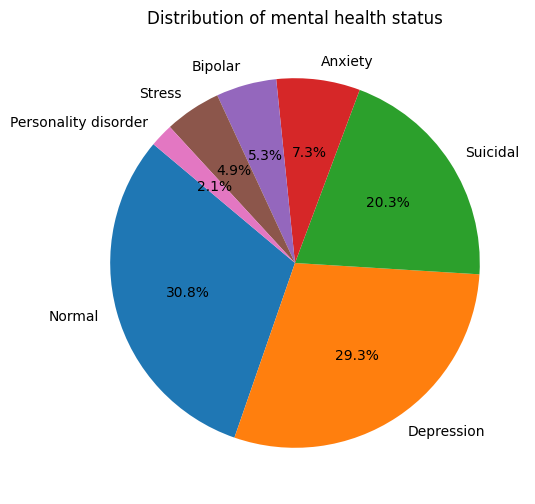

In [45]:
count=data_cleaned['status'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(count, labels=count.index, autopct='%1.1f%%',startangle=140)
plt.title("Distribution of mental health status")
plt.show()

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Unidirectional LSTM with dropout for regularization
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Embedding layer
        embedded = self.embedding(x)
        
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM layer
        out, (hn, cn) = self.lstm(embedded)
        
        # Fully connected layer (using the last time-step output)
        out = self.fc(hn[-1])
        return out

# Model Parameters
vocab_size = len(vectorizer.vocabulary_)
embedding_dim = 300  # You can adjust this or load pre-trained embeddings
hidden_size = 128
output_size = len(label_encoder.classes_)
num_layers = 2
dropout = 0.3

# Initialize model, loss, and optimizer
model = LSTMClassifier(vocab_size, embedding_dim, hidden_size, output_size, num_layers=num_layers, dropout=dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training Function
def train_model(model, train_loader, criterion, optimizer, epochs=30):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(torch.long).to(model.fc.weight.device), labels.to(model.fc.weight.device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(torch.long).to(model.fc.weight.device), labels.to(model.fc.weight.device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Train the model
train_model(model, train_loader, criterion, optimizer)

# Evaluate the model
evaluate_model(model, test_loader)


Epoch 1/30, Loss: 1.4306720564173054
Epoch 2/30, Loss: 1.3461140218209278
Epoch 3/30, Loss: 1.3194183281748988
Epoch 4/30, Loss: 1.308924871129714
Epoch 5/30, Loss: 1.2981182583572295
Epoch 6/30, Loss: 1.291159560056219
Epoch 7/30, Loss: 1.2842964376670223
Epoch 8/30, Loss: 1.284373058031683
Epoch 9/30, Loss: 1.2800332977347177
Epoch 10/30, Loss: 1.277700544129405
Epoch 11/30, Loss: 1.2730654493495934
Epoch 12/30, Loss: 1.2701805291110522
Epoch 13/30, Loss: 1.2728343937132094
Epoch 14/30, Loss: 1.2683291845307139
Epoch 15/30, Loss: 1.2683724900721778
Epoch 16/30, Loss: 1.2705879113445544
Epoch 17/30, Loss: 1.2689664586131069
Epoch 18/30, Loss: 1.2691129162068417
Epoch 19/30, Loss: 1.2674075392283262
Epoch 20/30, Loss: 1.2660705952520965
Epoch 21/30, Loss: 1.2674108463335254
Epoch 22/30, Loss: 1.2669003584976428
Epoch 23/30, Loss: 1.2648776228932304
Epoch 24/30, Loss: 1.2663563205045472
Epoch 25/30, Loss: 1.266576735940698
Epoch 26/30, Loss: 1.2651235633607687
Epoch 27/30, Loss: 1.26612

In [ ]:
def classify_text(model, text, vectorizer, label_encoder):
    model.eval()
    # Convert text to a sequence of token IDs
    sequence = torch.tensor(vectorizer.transform([text]).toarray().argmax(axis=1)).to(torch.long)
    
    # Reshape to add batch dimension (1, sequence_length) since LSTM expects 3D input (batch_size, sequence_length, input_size)
    sequence = sequence.unsqueeze(0)  # Adding batch dimension
    
    with torch.no_grad():
        output = model(sequence)
        _, predicted_label = torch.max(output, 1)
    
    # Decode predicted label
    return label_encoder.inverse_transform(predicted_label.cpu().numpy())[0]

# Test the classification on a new sample text
sample_text = "I feel extremely anxious and stressed."
predicted_category = classify_text(model, sample_text, vectorizer, label_encoder)
print(f"Sample text: '{sample_text}'")
print(f"Predicted mental health category: {predicted_category}")


Sample text: 'I feel extremely anxious and stressed.'
Predicted mental health category: Anxiety


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout_prob=0.5):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob

        # Embedding layer
        self.embedding = nn.Embedding(input_size, 128)
        
        # Dropout layer for Bayesian approximation (MC Dropout)
        self.dropout = nn.Dropout(dropout_prob)

        # RNN layers
        self.rnn = nn.RNN(input_size=128, hidden_size=hidden_size, num_layers=num_layers, 
                          batch_first=True, dropout=dropout_prob)
        
        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Embedding layer with dropout
        embedded = self.dropout(self.embedding(x))
        
        # Initial hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Pass through RNN layer
        out, _ = self.rnn(embedded, h0)
        
        # Dropout before the fully connected layer
        out = self.dropout(out[:, -1, :])  # Use the last output
        out = self.fc(out)
        
        return out

# Training function
def train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(torch.long).to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

# Evaluation function with MC Dropout
def evaluate(model, test_loader, n_samples=30):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(torch.long).to(device), labels.to(device)
            
            # Use MC Dropout for predictions
            predictions = []
            for _ in range(n_samples):
                model.train()  # Enable dropout
                output = model(inputs)
                predictions.append(F.softmax(output, dim=1).cpu().numpy())
            
            # Average predictions over multiple samples for MC Dropout
            predictions = torch.tensor(predictions).mean(dim=0)
            _, predicted_labels = torch.max(predictions, 1)
            
            all_predictions.extend(predicted_labels.numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy

# Initialize model, loss function, and optimizer
input_size = 5000  # Adjust based on TF-IDF features
hidden_size = 128
output_size = len(label_encoder.classes_)  # Number of unique categories
dropout_prob = 0.5
num_epochs = 30
learning_rate = 0.001

model = RNNClassifier(input_size=input_size, hidden_size=hidden_size, 
                      output_size=output_size, dropout_prob=dropout_prob)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")

    # Evaluate on test data
    test_accuracy = evaluate(model, test_loader)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

print("Training and evaluation complete.")


Epoch [1/30], Loss: 1.5825


C:\Users\kanda\AppData\Local\Temp\ipykernel_6068\847758317.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  predictions = torch.tensor(predictions).mean(dim=0)


Test Accuracy: 42.29%
Epoch [2/30], Loss: 1.5033
Test Accuracy: 44.96%
Epoch [3/30], Loss: 1.4672
Test Accuracy: 44.99%
Epoch [4/30], Loss: 1.4430


KeyboardInterrupt: 

In [ ]:
def classify_text(model, text, vectorizer, label_encoder):
    model.eval()
    # Convert text to a sequence of token IDs
    sequence = torch.tensor(vectorizer.transform([text]).toarray().argmax(axis=1)).to(torch.long)
    
    # Reshape to add batch dimension (1, sequence_length) since LSTM expects 3D input (batch_size, sequence_length, input_size)
    sequence = sequence.unsqueeze(0)  # Adding batch dimension
    
    with torch.no_grad():
        output = model(sequence)
        _, predicted_label = torch.max(output, 1)
    
    # Decode predicted label
    return label_encoder.inverse_transform(predicted_label.cpu().numpy())[0]

# Test the classification on a new sample text
sample_text = "I feel extremely anxious and stressed."
predicted_category = classify_text(model, sample_text, vectorizer, label_encoder)
print(f"Sample text: '{sample_text}'")
print(f"Predicted mental health category: {predicted_category}")

